# Target Variable Processing

In this notebook, the developed class for deep investigation of target variable is illustrated for electricity consumption data. 

Data source: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

The section 1 identifies missing, unique, and outlier values. It results in cleaned data for any data analysis or modeling. Subsequently, section 2 and 3 indicates basic characteristics of time series (seasonality, trend, stationary etc.). In section 4, correlation with previous values and time parameters are evaluated. Based on the outcomes, dataframes of relevant features are created which are used in further modeling. 

1. Missing, unique, and outliers values
    - Number of missing and outlier values are examined and imputed before any further processing. Number of unique values indicates whether target variable is a categorical or continous value. 

2. Data Visualisation
    - Daily, weekly, and monthly data is plotted to identify seasonality and trend of the series.

3. Stationarity
    - For time series, Augumented-Dickey Fuller Test is performed.

4. Feature engineering
    - *Autocorrelation* : Correlation of the current value to previous lags is determiend. 
    - *Time parameters*:  Influence of hour of the day, day of the month, week day, and month of the year on electricity consumption is also understood. 

    Lags and time parameters of strong correlation are added as features.

In [5]:
import pandas as pd
from datetime import timedelta

from TimeindexProcessing import TimeindexProcessing as TP
from TargetVariableProcessing import TargetVariableProcessing as TVP

In [6]:
df = pd.read_csv('./Data/Kaggle_PJME/''PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


**Converting Datetime column to timeseries index**

In [9]:
index_processing = TP()
indexed_df = index_processing.convert_column_to_timeindex(df, column_name= 'Datetime')
output_series = indexed_df['PJME_MW']
output_series.head(4)

Datetime
2002-12-31 01:00:00    26498.0
2002-12-31 02:00:00    25147.0
2002-12-31 03:00:00    24574.0
2002-12-31 04:00:00    24393.0
Name: PJME_MW, dtype: float64

In [8]:
tvp = TVP(output_series)

**Section 1: Missing, unique, and outliers values**

Before proceeding to any analysis, it is worth to explore missing values, and types (categorical/numerical) of target variable(s). The histogram can also indicate any outliers of the series.

In [10]:
missing_values = tvp.missing_values()
missing_values

0

In [11]:
unique_value_counts = tvp.unique_value_counts()
unique_value_counts

28441

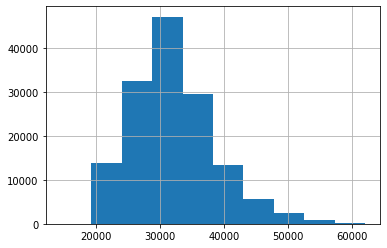

In [12]:
output_series.hist();

There is neither a missing value nor an outlier.

**Section 2: Data Visualisation**

Daily, weekly, and monthly electricity consumption is plotted from the same start date by using plotting timeseries method. The plots provide useful information of seasonality and trend. 

In [13]:
start_date = '2003-12-31'

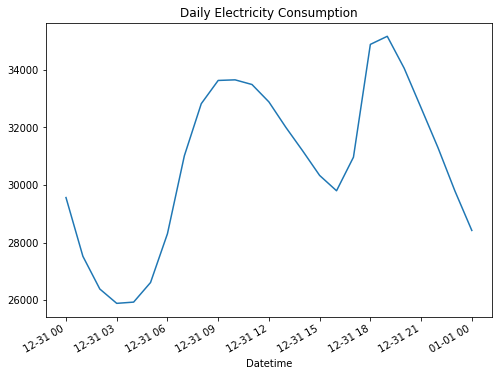

In [10]:
## Daily consumption day=te
days, title = 1, 'Daily Electricity Consumption'
plot = tvp.plotting_timeseries(output_series, 
                             start_date = start_date, 
                             days = days, 
                             figsize = (8,6), 
                             title = title)

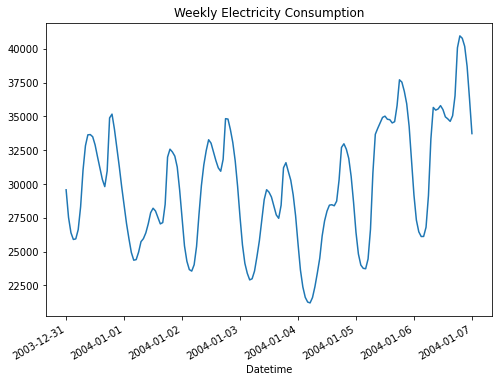

In [11]:
days, title = 7, 'Weekly Electricity Consumption'
plot = tvp.plotting_timeseries(output_series, 
                                start_date = start_date, 
                                days = days, 
                                figsize = (8,6), 
                                title = title)

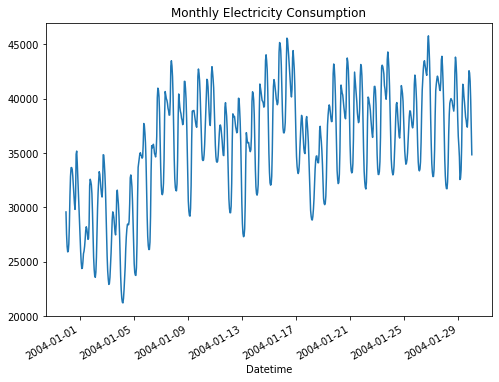

In [12]:
# start_date = '2004-02-01'
days, title = 30, 'Monthly Electricity Consumption'
plot = tvp.plotting_timeseries(output_series, 
                             start_date = start_date, 
                             days = days, 
                            figsize = (8,6), 
                            title = title)

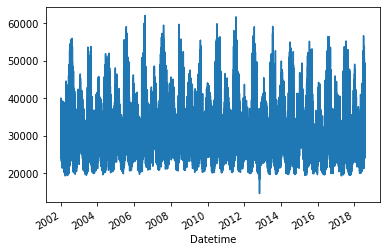

In [15]:
output_series.plot();

Everyday, consumption has two peaks around 9 AM and 6 PM while the daily mininum is around 3 AM. It is observed in all three daily, weekly, and monthly plots. There is no clear trend in the data.

In the monthly figures, it seems that electricity consumption is lower in the beginning of the month. It is a coincident of holiday season in the beginning of January. It was verifeid by examining other months data. 

## Section 3: Stationarity of output series

Based on ADF test, it can be determined whether output series is stationary or not.

In [16]:
adf_result = tvp.stationarity()

stationary


Though the test result shows that time-series is stationary but there is clear seasonality in data. 

## Section 4: Feature Engineering

### Section 4.1 Dependence of electiricy consumption on time paramters

A time series can be dependent on hour of the day, day of the week, month of the year and other time gaps. It is also possible that none of these parameters affect the output. Below, correlation of electricity consumption with hour, day, month, weekday are  calculated.

In [17]:
time_parameters = ['hour', 'day', 'month', 'weekday']
time_correlation = tvp.correlation_to_timeperiod(time_parameters)
time_correlation

PJME_MW        1.000000
hour           0.486303
day            0.000077
month         -0.044522
weekday       -0.183058
working day   -0.224173
Name: PJME_MW, dtype: float64

As expected, hour of the day strongly influences on energy consumption. Along with hour of day, wethere a day is working or weekday, also affects electricity consumption. These features are created by using create_time_features methods.

In [20]:
#Creating time featurs 
time_features_to_add = ['hour', 'working day']
time_features_df = tvp.create_time_features(time_features_to_add)
time_features_df.head()

,hour,working day
Datetime,,
2002-12-31 01:00:00,1,0
2002-12-31 02:00:00,2,0
2002-12-31 03:00:00,3,0
2002-12-31 04:00:00,4,0
2002-12-31 05:00:00,5,0



### Section 4.2 Correlation to previous values

In most of the time series, the output has correlation of the previous values. Correlation of one week lags (24*7) are evaluated and based on these values, highly correlated lags are determined. Values of these previous lags are considered as input features while modeling.

In [ ]:
autocorrelation = tvp.autocorrelation(lag_number = 24*7)
autocorrelation.nlargest(10)

1      0.970262
2      0.898283
24     0.890609
25     0.867789
23     0.862944
26     0.805216
3      0.798230
22     0.795809
168    0.778797
48     0.771718
dtype: float64

The current value has a strong correlation to 1 and 2 lags which correspond to one and two hours previous values. The previous day value at the same hour (lag = 24) has a correlation value of 0.89. Below, these three lags are created from the method create_lag_features. 

In [21]:
#Creating lag features
added_lags = [1, 2, 24]
added_lags_df = tvp.create_lag_features(added_lags)
added_lags_df.head()

,PJME_MW_lag1,PJME_MW_lag2,PJME_MW_lag24
Datetime,,,
2002-12-31 01:00:00,NaN,NaN,NaN
2002-12-31 02:00:00,26498.0,NaN,NaN
2002-12-31 03:00:00,25147.0,26498.0,NaN
2002-12-31 04:00:00,24574.0,25147.0,NaN
2002-12-31 05:00:00,24393.0,24574.0,NaN


In [23]:
input_features_df = pd.concat([time_features_df, added_lags_df], axis = 1)
input_features_df.head()

,hour,working day,PJME_MW_lag1,PJME_MW_lag2,PJME_MW_lag24
Datetime,,,,,
2002-12-31 01:00:00,1,0,NaN,NaN,NaN
2002-12-31 02:00:00,2,0,26498.0,NaN,NaN
2002-12-31 03:00:00,3,0,25147.0,26498.0,NaN
2002-12-31 04:00:00,4,0,24574.0,25147.0,NaN
2002-12-31 05:00:00,5,0,24393.0,24574.0,NaN


Thorough data processing of target variables resulted in cleaned output series and dataframe of relevant features.